## Kue Dataset - Model4_2

Model4_2


In [141]:
# conda install -c conda-forge keras

In [142]:
import os
import re
import glob

import scipy.io
import cv2
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.io import loadmat
import random
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt


In [143]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [144]:
# PATH_DATA = '../data/'
# PATH_DATA_IMAGES = '../../../../My_Dataset/images/dataset257/'
PATH_DATA_IMAGES = 'drive/MyDrive/Repository/Data/dataset257/'
PATH_DATA_TRAIN = PATH_DATA_IMAGES+'train/'
PATH_DATA_VAL = PATH_DATA_IMAGES+'validation/'
PATH_DATA_TEST = PATH_DATA_IMAGES+'test/'
PATH_MODEL = 'drive/MyDrive/Repository/Model/'

In [145]:
os.listdir(PATH_DATA_TRAIN)

['.DS_Store',
 'kue_kastengel',
 'kue_dadar_gulung',
 'kue_risoles',
 'kue_klepon',
 'kue_putri_salju',
 'kue_lumpur',
 'kue_lapis',
 'kue_serabi']

## Modeling

In [147]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import metrics, optimizers
import keras
import tensorflow as tf
from keras.models import load_model


In [148]:
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
# tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [149]:
## label dict
lab = [i for i in os.listdir(PATH_DATA_TRAIN) if '.' not in i]
lab.sort()

label_dict = dict(zip(lab,[i for i in range(len(lab))]))
label_dict

{'kue_dadar_gulung': 0,
 'kue_kastengel': 1,
 'kue_klepon': 2,
 'kue_lapis': 3,
 'kue_lumpur': 4,
 'kue_putri_salju': 5,
 'kue_risoles': 6,
 'kue_serabi': 7}

In [150]:
LABEL_SIZE = len(label_dict.keys())
IMAGE_SIZE = 128

In [151]:
# ?Conv2D

In [153]:
just_cake_model = load_model(PATH_MODEL +'just_cake_model-colab3.h5',compile=False)

In [154]:
just_cake_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 128)     3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 128)     147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 256)       0

In [167]:
## compile model
opt = optimizers.Adam(learning_rate=0.00001)
just_cake_model.compile(
              loss='categorical_crossentropy',
              #optimizer='rmsprop',
              optimizer = opt,
              metrics=['accuracy',
                      #  metrics.SparseCategoricalAccuracy(),
                       metrics.AUC()])

In [168]:
## data generator
BATCH_SIZE = 32
# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         zoom_range=0.15,
#         rotation_range=40,
#         width_shift_range=0.25,
#         height_shift_range=0.25,
#         # shear_range=0.25,
#         # horizontal_flip=True
#         )

train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.15,
        rotation_range=65,
        width_shift_range=0.4,
        height_shift_range=0.4,
        shear_range=0.5,
        # horizontal_flip=True
        )

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

## Shuffle = True
train_generator = train_datagen.flow_from_directory(
        PATH_DATA_TRAIN,  
        target_size=(IMAGE_SIZE, IMAGE_SIZE), 
        batch_size=BATCH_SIZE,
        seed=301,
        class_mode="categorical" )  

val_generator = val_datagen.flow_from_directory(
        PATH_DATA_VAL,  
        target_size=(IMAGE_SIZE, IMAGE_SIZE), 
        batch_size=BATCH_SIZE,
        seed=301,
        class_mode="categorical" )  

test_generator = test_datagen.flow_from_directory(
        PATH_DATA_TEST,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        seed=301,
        class_mode="categorical" )

Found 1516 images belonging to 8 classes.
Found 160 images belonging to 8 classes.
Found 160 images belonging to 8 classes.


In [175]:
## save best model and use early stopping
early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',mode='min', patience=8) 
check_p = keras.callbacks.ModelCheckpoint(
        filepath=PATH_MODEL+'just_cake_model-colab4_2.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True)

epoch_hist = just_cake_model.fit(
        train_generator,
        steps_per_epoch=1516 // BATCH_SIZE,
        validation_data=val_generator,
        validation_steps=160 // BATCH_SIZE,
        callbacks=[early_stop,check_p],
        epochs=8)

Epoch 1/8
47/47 [==============================] - 32s 675ms/step - loss: 0.5204 - accuracy: 0.8592 - auc_18: 0.9775 - val_loss: 1.1844 - val_accuracy: 0.7750 - val_auc_18: 0.9411
Epoch 2/8
47/47 [==============================] - 32s 679ms/step - loss: 0.5951 - accuracy: 0.8477 - auc_18: 0.9718 - val_loss: 1.1743 - val_accuracy: 0.7812 - val_auc_18: 0.9416
Epoch 3/8
47/47 [==============================] - 32s 673ms/step - loss: 0.5472 - accuracy: 0.8470 - auc_18: 0.9773 - val_loss: 1.1536 - val_accuracy: 0.7875 - val_auc_18: 0.9414
Epoch 4/8
47/47 [==============================] - 32s 669ms/step - loss: 0.5376 - accuracy: 0.8524 - auc_18: 0.9761 - val_loss: 1.1567 - val_accuracy: 0.7875 - val_auc_18: 0.9416
Epoch 5/8
47/47 [==============================] - 32s 678ms/step - loss: 0.4839 - accuracy: 0.8625 - auc_18: 0.9784 - val_loss: 1.1534 - val_accuracy: 0.7812 - val_auc_18: 0.9415
Epoch 6/8
47/47 [==============================] - 32s 677ms/step - loss: 0.5443 - accuracy: 0.8457 

## Evaluations

In [176]:
df_epoch_hist = pd.DataFrame(epoch_hist.history)

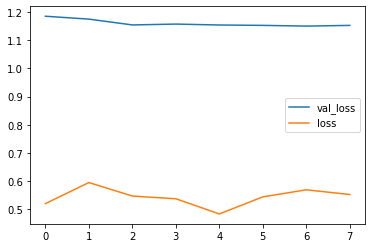

In [177]:
df_epoch_hist[['val_loss','loss']].plot()

In [178]:
# depd = {'auc_1' : metrics.AUC}
model_load4_2 = load_model(PATH_MODEL + 'just_cake_model-colab4_2.h5')
model_load3 = load_model(PATH_MODEL + 'just_cake_model-colab3.h5')

In [179]:
model_load3.evaluate(val_generator)

5/5 [==============================] - 2s 397ms/step - loss: 1.3944 - accuracy: 0.7688 - auc_9: 0.9383


[1.3944469690322876, 0.768750011920929, 0.9382812976837158]

In [180]:
model_load4_2.evaluate(val_generator)

5/5 [==============================] - 2s 398ms/step - loss: 1.1495 - accuracy: 0.7937 - auc_18: 0.9416


[1.1495448350906372, 0.793749988079071, 0.9415680170059204]

In [193]:
def eval_model(gen_,model_load):
  per = np.random.permutation(gen_.n)
  gen_.index_array = per
  y_true = gen_.classes[per]

  predictions = model_load.predict(gen_)
  y_pred = np.argmax(predictions, axis=1)

  cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
  plt.figure(figsize = (12,8))
  sns.heatmap(cm, annot= True)
  print(classification_report(y_true, y_pred))

#### 1. Train

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       192
           1       0.82      0.89      0.85       181
           2       0.96      0.93      0.95       197
           3       0.82      0.83      0.82       201
           4       0.91      0.84      0.87       197
           5       0.90      0.88      0.89       172
           6       0.85      0.84      0.85       196
           7       0.77      0.78      0.77       180

    accuracy                           0.85      1516
   macro avg       0.85      0.85      0.85      1516
weighted avg       0.85      0.85      0.85      1516



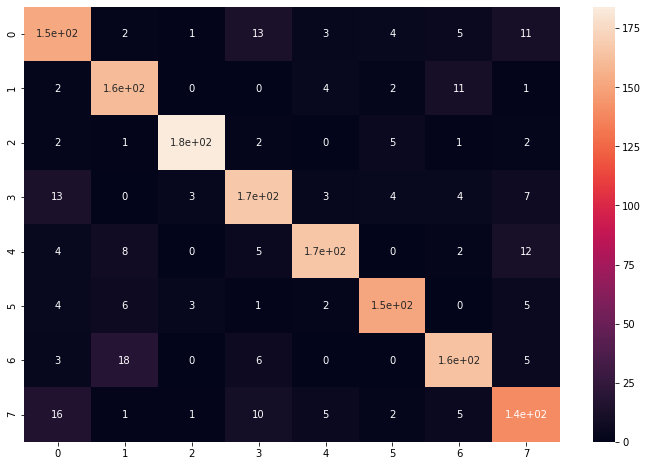

In [194]:
eval_model(train_generator, model_load4_2)

#### 2. Validations

              precision    recall  f1-score   support

           0       0.71      0.60      0.65        20
           1       0.75      0.75      0.75        20
           2       0.91      1.00      0.95        20
           3       0.72      0.65      0.68        20
           4       0.84      0.80      0.82        20
           5       1.00      0.90      0.95        20
           6       0.81      0.85      0.83        20
           7       0.64      0.80      0.71        20

    accuracy                           0.79       160
   macro avg       0.80      0.79      0.79       160
weighted avg       0.80      0.79      0.79       160



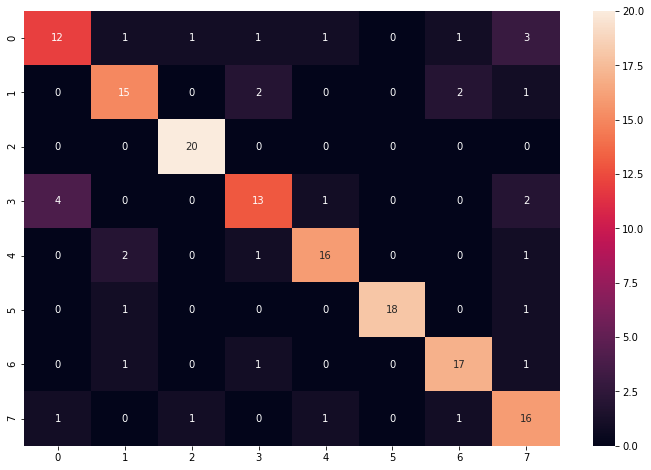

In [195]:
eval_model(val_generator, model_load4_2)

#### 3. Test

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        20
           1       0.87      0.91      0.89        22
           2       0.95      1.00      0.98        20
           3       0.82      0.70      0.76        20
           4       0.84      0.80      0.82        20
           5       0.89      0.94      0.92        18
           6       0.78      0.90      0.84        20
           7       0.94      0.75      0.83        20

    accuracy                           0.86       160
   macro avg       0.87      0.86      0.86       160
weighted avg       0.86      0.86      0.86       160



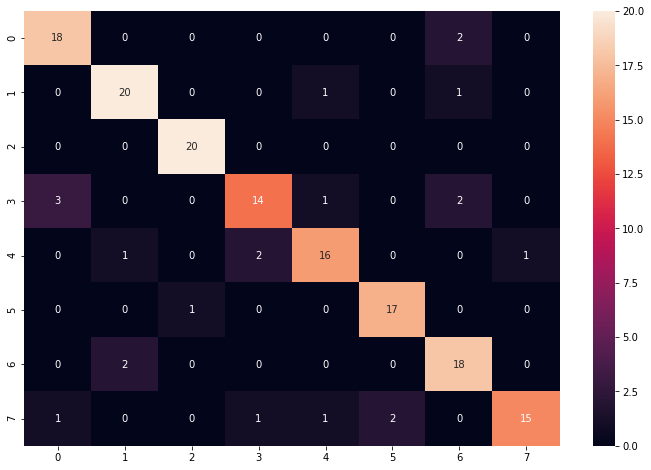

In [196]:
eval_model(test_generator, model_load4_2)

              precision    recall  f1-score   support

           0       0.81      0.85      0.83        20
           1       1.00      0.77      0.87        22
           2       1.00      1.00      1.00        20
           3       0.78      0.70      0.74        20
           4       0.80      0.80      0.80        20
           5       0.90      1.00      0.95        18
           6       0.77      1.00      0.87        20
           7       0.83      0.75      0.79        20

    accuracy                           0.86       160
   macro avg       0.86      0.86      0.86       160
weighted avg       0.86      0.86      0.85       160



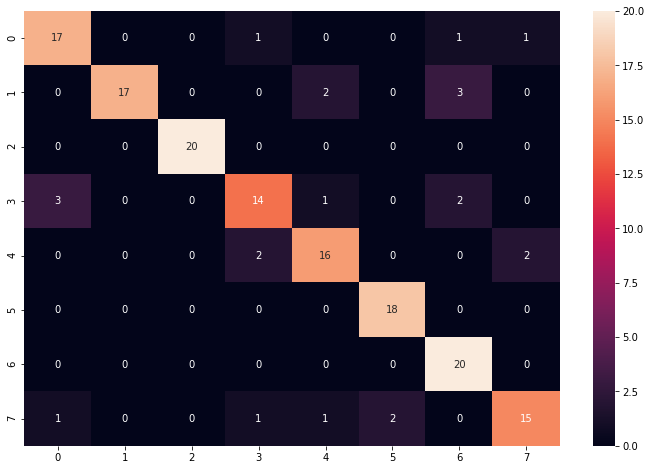

In [197]:
eval_model(test_generator, model_load3)